In [94]:
import mdp
import pickle

In [95]:
! python mdp.py < ex.mdp

States: ['S0', 'S1', 'S2']
Actions: ['a', 'b']
Transition from S0 with no action and targets ['S1', 'S2'] with weights [5, 5]
Transition from S1 with action b and targets ['S1', 'S0'] with weights [2, 8]
Transition from S1 with action a and targets ['S2', 'S0', 'S1'] with weights [1, 3, 6]
Transition from S2 with action c and targets ['S0', 'S1'] with weights [5, 5]
{'States': ['S0', 'S1', 'S2'], 'Actions': ['a', 'b'], 'Transitions_with_action': {1: {'from': 'S1', 'action': 'b', 'targets': ['S1', 'S0'], 'weights': [2, 8]}, 2: {'from': 'S1', 'action': 'a', 'targets': ['S2', 'S0', 'S1'], 'weights': [1, 3, 6]}, 3: {'from': 'S2', 'action': 'c', 'targets': ['S0', 'S1'], 'weights': [5, 5]}}, 'Transitions_without_action': {0: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}}}


In [96]:
# On lit le .pickle des données que l'on souhaitent récupérer

# Read list to memory
def read_list(nom_liste):
    # for reading also binary mode is important
    with open(nom_liste, 'rb') as fp:
        liste = pickle.load(fp)
        return liste

L = read_list("liste_donnees")
print('Données récupérées', L)

Données récupérées {'States': ['S0', 'S1', 'S2'], 'Actions': ['a', 'b'], 'Transitions_with_action': {1: {'from': 'S1', 'action': 'b', 'targets': ['S1', 'S0'], 'weights': [2, 8]}, 2: {'from': 'S1', 'action': 'a', 'targets': ['S2', 'S0', 'S1'], 'weights': [1, 3, 6]}, 3: {'from': 'S2', 'action': 'c', 'targets': ['S0', 'S1'], 'weights': [5, 5]}}, 'Transitions_without_action': {0: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}}}


In [97]:
print('States:', L['States'])
print('Actions:', L['Actions'])
for transitions in L['Transitions_with_action']:
    print('Transition with action' ':', L['Transitions_with_action'][transitions])
for transitions in L['Transitions_without_action']:
    print('Transition without action' ':', L['Transitions_without_action'][transitions])

States: ['S0', 'S1', 'S2']
Actions: ['a', 'b']
Transition with action: {'from': 'S1', 'action': 'b', 'targets': ['S1', 'S0'], 'weights': [2, 8]}
Transition with action: {'from': 'S1', 'action': 'a', 'targets': ['S2', 'S0', 'S1'], 'weights': [1, 3, 6]}
Transition with action: {'from': 'S2', 'action': 'c', 'targets': ['S0', 'S1'], 'weights': [5, 5]}
Transition without action: {'from': 'S0', 'targets': ['S1', 'S2'], 'weights': [5, 5]}


In [98]:
import graphviz

dot = graphviz.Digraph(comment='Processus de Décision Markoviens')

for i, state in enumerate(L['States']):
    dot.node(str(i), state)

dot.edges(['02','12'])
dot.edge('0', '1', label='test')

Utiliser la bibliothèque graphviz pour l'affichage. 
Quelques liens utiles :

Les attributs possibles pour les différentes fonctions : https://www.graphviz.org/doc/info/attrs.html

Doc graphviz : https://graphviz.readthedocs.io/en/stable/manual.html

In [99]:
print(dot.source)

// Processus de Décision Markoviens
digraph {
	0 [label=S0]
	1 [label=S1]
	2 [label=S2]
	0 -> 2
	1 -> 2
	0 -> 1 [label=test]
}



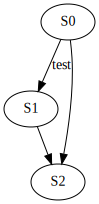

In [100]:
dot